In [1]:
from summit.domain import Domain, ContinuousVariable, Constraint
from summit.strategies import Random, LHS, NelderMead
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [17]:
# Single-objective optimization problem with 2 dimensional input domain (only continuous inputs)
domain = Domain()
maximize = True
constraint = True
domain += ContinuousVariable(name='temperature', description='reaction temperature in celsius', bounds=[-4, 4])
domain += ContinuousVariable(name='flowrate_a', description='flow of reactant a in mL/min', bounds=[-6, 6])
domain += ContinuousVariable(name='yield', description='relative conversion to xyz',
                             bounds=[-1000,1000], is_objective=True, maximize=maximize)
domain += Constraint(lhs="temperature+flowrate_a+7", constraint_type=">=")
domain += Constraint(lhs="temperature*flowrate_a+10", constraint_type=">=")
domain

Name,Type,Description,Values
temperature,"continuous, input",reaction temperature in celsius,"[-4,4]"
flowrate_a,"continuous, input",flow of reactant a in mL/min,"[-6,6]"
yield,"continuous, maximize objective",relative conversion to xyz,"[-1000,1000]"
,constraint,temperature+flowrate_a+7,
,constraint,temperature*flowrate_a+10,


In [13]:
x_start = [0,0]
strategy = NelderMead(domain, x_start=x_start, adaptive=False)

Here we simulating experiments with hypothetical relationship of inputs and outputs,
Thhe [Himmelblau (2D) function](http://benchmarkfcns.xyz/benchmarkfcns/himmelblaufcn.html) is used.

In [14]:
def sim_fun(x_exp):
    x = x_exp
    y_exp = -((x[0]**2 + x[1] - 11)**2+(x[0] + x[1]**2 -7)**2)
    if not maximize:
        y_exp *= -1.0
    return y_exp
def test_fun(x):
    y = np.array([sim_fun(x[i]) for i in range(0, x.shape[0])])
    return y

Stopping criterion is reached.
Optimal setting: [3. 2.] with outcome: 0.0


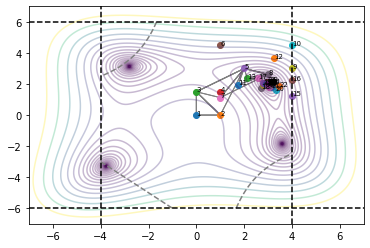

In [18]:
# run Nelder-Mead loop for fixed <num_iter> number of iteration
# stop loop if <max_stop> consecutive iterations have not produced an improvement
initial_exp = None
num_iter = 100
max_stop = 20
nstop = 0
fbestold = float("inf")
fig, ax = plt.subplots()
plt.axis([-7, 7, -7, 7])
patches = []
points = []
for i in range(num_iter):
    # initial run without history
    if i == 0:
        try:
            if initial_exp is not None:
                for i in range(len(initial_exp)):
                    points.append(initial_exp.data_to_numpy()[i][:2].tolist())
                polygon = Polygon(points, True, hatch='x')
                patches.append(polygon)
                next_experiments, xbest, fbest, param = strategy.suggest_experiments(prev_res=initial_exp)
            else:
                next_experiments, xbest, fbest, param = strategy.suggest_experiments()
        # TODO: how to handle internal errors? Here implemented as ValueError - maybe introduce a InternalError class for strategies
        except ValueError as e:
            print(e)
            break

    # runs with history
    else:
        # This is the part where experiments take place
        exp_yield = test_fun(next_experiments.data_to_numpy())
        next_experiments[('yield', 'DATA')] = exp_yield
        # Call Nelder-Mead Simplex
        try:
            next_experiments, xbest, fbest, param = \
                strategy.suggest_experiments(prev_res=next_experiments, prev_param=param)
        # TODO: how to handle internal stopping criteria? Here implemented as ValueError - maybe introduce a StoppingError class for strategies
        except (NotImplementedError, ValueError) as e:
            print(e)
            break

    x = np.asarray([param[0][0][i].tolist() for i in range(len(param[0][0]))])
    polygon = Polygon(x, True, hatch='x')
    patches.append(polygon)
    for i in range(len(next_experiments)):
        points.append(next_experiments.data_to_numpy()[i].tolist())

    if fbest < fbestold:
        fbestold = fbest
        nstop = 0
    else:
        nstop += 1
    if nstop >= max_stop:
        print("No improvement in last " + str(max_stop) + " iterations.")
        break
xbest = np.around(xbest, decimals=3)
fbest = np.around(fbest, decimals=3)

assert fbest <= 0.1
print("Optimal setting: " + str(xbest) + " with outcome: " + str(fbest))
# Extrema of test function without constraints: four identical local minima f = 0 at x1 = (3.000, 2.000),
# x2 = (-2.810, 3.131), x3 = (-3.779, -3.283), x4 = (3.584, -1.848)

xlist = np.linspace(-7, 7, 1000)
ylist = np.linspace(-7, 7, 1000)
X, Y = np.meshgrid(xlist, ylist)
Z = (((X**2 + Y - 11)**2+(X + Y**2 -7)**2))
ax.contour(X,Y,Z, levels=np.logspace(-2, 3, 30, base=10), alpha=0.3)
p = PatchCollection(patches, facecolors="None", edgecolors='grey', alpha=1)
ax.add_collection(p)
for c in range(len(points)):
    ax.scatter(points[c][0], points[c][1])
    ax.text(points[c][0] + .01, points[c][1] + .01, c+1, fontsize=7)
ax.axvline(x=-4, color='k', linestyle='--')
ax.axhline(y=6, color='k', linestyle='--')
ax.axvline(x=4, color='k', linestyle='--')
ax.axhline(y=-6, color='k', linestyle='--')
if constraint:
    x = np.linspace(-4, 4, 400)
    y = np.linspace(-6, 6, 400)
    x, y = np.meshgrid(x, y)
    ax.contour(x, y, (x*y+10), [0], colors='grey',linestyles='dashed')
    ax.contour(x, y, (x+y+7), [0], colors='grey', linestyles='dashed')
plt.show()

In [21]:
x_start = [0,0,0]
maximize = True


Stopping criterion is reached.


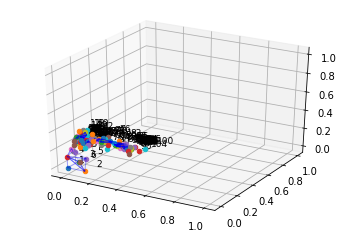

Optimal setting: [0.368 0.117 0.268] with outcome: -1.001


In [23]:
# Single-objective optimization problem with 3 dimensional input domain (only continuous inputs)
domain = Domain()
domain += ContinuousVariable(name='temperature', description='reaction temperature in celsius', bounds=[0, 1])
domain += ContinuousVariable(name='flowrate_a', description='flow of reactant a in mL/min', bounds=[0, 1])
domain += ContinuousVariable(name='flowrate_b', description='flow of reactant b in mL/min', bounds=[0, 1])
domain += ContinuousVariable(name='yield', description='relative conversion to xyz',
                             bounds=[-1000,1000], is_objective=True, maximize=maximize)
#domain += Constraint(lhs="flowrate_a+flowrate_b-1.1", constraint_type="<=")   # try with x_start = []
strategy = NelderMead(domain,x_start=x_start)

# Simulating experiments with hypothetical relationship of inputs and outputs,
# here Hartmann 3D function: https://www.sfu.ca/~ssurjano/hart3.html
def sim_fun(x_exp):
    x_exp = x_exp[:3]
    A = np.array([[3,10,30],[0.1,10,35],[3,10,30],[0.1,10,35]])
    P = np.array([[3689,1170,2673],[4699,4387,7470],[1091,8732,5547],[381,5743,8828]])*10**(-4)
    alpha = np.array([1,1.2,3.0,3.2])
    d = np.zeros((4,1))
    for k in range(4):
        d[k] = np.sum(np.dot(A[k,:],(x_exp-P[k,:])**2))
    y_exp = np.sum(np.dot(alpha,np.exp(-d)))
    if not maximize:
        y_exp = - y_exp
    return y_exp
def test_fun(x):
    y = np.array([sim_fun(x[i]) for i in range(0, x.shape[0])])
    return y
# Define hypothetical constraint (for real experiments, check constraint and return NaN)

# Uncomment to create test case which results in reduction dimension and dimension recovery
initial_exp = None
#initial_exp = pd.DataFrame(data={'temperature': [0.1,0.1,0.4,0.3], 'flowrate_a': [0.6,0.2,0.4,0.5], 'flowrate_b': [1,1,1,0.3]})   # initial experimental points
#initial_exp.insert(3,'yield', test_fun(initial_exp.to_numpy()))   # initial results
#initial_exp = DataSet.from_df(initial_exp)

# run Nelder-Mead loop for fixed <num_iter> number of iteration
# stop loop if <max_stop> consecutive iterations have not produced an improvement
num_iter = 200
max_stop = 20
nstop = 0
fbestold = float("inf")
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
points = []
for i in range(num_iter):
    # initial run without history
    if i == 0:
        try:
            if initial_exp is not None:
                next_experiments, xbest, fbest, param = strategy.suggest_experiments(prev_res=initial_exp)

                for i in range(len(initial_exp)):
                    points.append(initial_exp.data_to_numpy()[i][:3].tolist())
                x = np.asarray(
                    [(initial_exp.data_to_numpy()[i][:3].tolist(), initial_exp.data_to_numpy()[j][:3])
                     for i in range(len(initial_exp.data_to_numpy())) for j in range(len(initial_exp.data_to_numpy()))])
                polygon = Poly3DCollection(x, alpha=0.1)
                polygon.set_edgecolor('b')
                ax.add_collection3d(polygon)
            else:
                next_experiments, xbest, fbest, param = strategy.suggest_experiments()
        # TODO: how to handle internal errors? Here implemented as ValueError - maybe introduce a InternalError class for strategies
        except ValueError as e:
            print(e)
            break


    # runs with history
    else:
        # This is the part where experiments take place
        exp_yield = test_fun(next_experiments.data_to_numpy())
        next_experiments['yield', 'DATA'] = exp_yield
        try:
            next_experiments, xbest, fbest, param = \
                strategy.suggest_experiments(prev_res=next_experiments, prev_param=param)
        # TODO: how to handle internal stopping criteria? Here implemented as ValueError - maybe introduce a StoppingError class for strategies
        except (ValueError, NotImplementedError) as e:
            print(e)
            break

    x = np.asarray([(param[0][0][i].tolist(),param[0][0][j].tolist()) for i in range(len(param[0][0])) for j in range(len(param[0][0]))])
    polygon = Poly3DCollection(x, alpha=0.1)
    polygon.set_edgecolor('b')
    ax.add_collection3d(polygon)
    for i in range(len(next_experiments)):
        points.append(next_experiments.data_to_numpy()[i].tolist())

    if fbest < fbestold:
        fbestold = fbest
        nstop = 0
    else:
        nstop += 1
    if nstop >= max_stop:
        print("No improvement in last " + str(max_stop) + " iterations.")
        break

for c in range(len(points)):
    ax.scatter(points[c][0], points[c][1], points[c][2])
    ax.text(points[c][0] + .05, points[c][1] + .05, points[c][2] + .05, c+1, fontsize=9)
plt.show()
plt.close()

xbest = np.around(xbest, decimals=3)
fbest = np.around(fbest, decimals=3)

print("Optimal setting: " + str(xbest) + " with outcome: " + str(fbest))